In [1]:
from pathlib import Path
import pydicom as dcm
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# from createMovie import dicomVideo
from segment_a4c_a2c_a3c_plax_psax import *
from echoanalysis_tools import *

In [2]:
df = pd.read_csv("../playground/maddie_verified_20220808.csv", index_col=0)

In [3]:
def getView(v):
    return [f"{x}_raw" for x in df[df.Maddie == v].filename]

In [4]:
a4c = getView('a4c')
a3c = getView('a3c')
a2c = getView('a2c')
plax = getView('plax')

In [5]:
d = dcm.dcmread(Path("/data2/NMEcho/jtw_echo2/jpgs/")/a3c[0])

In [6]:
ddeo = dcm.dcmread("dicomsample/Image-43.dcm", force=True)

In [7]:
dtemp = dcm.pixel_data_handlers.util.convert_color_space(ddeo.pixel_array, "YBR_FULL_422", "RGB")

In [15]:
import tensorflow as tf
import os
tf = tf.compat.v1

In [ ]:
means = np.zeros_like(a3c, dtype=float)
for i in range(len(a3c)):
    d = dcm.dcmread(dicomdir + a3c[i])
    means[i] = d.pixel_array.mean()
print(means.mean())

In [199]:
view = "a4c"
mean = 24
weight_decay = 1e-12
learning_rate = 1e-4
maxout = False
config = tf.ConfigProto(device_count = {'GPU': 1})
sesses = []
models = []

model_dir = "/data2/NMEcho/echo_testing/"

g_1 = tf.Graph()
if view == "a4c":
    g_1 = tf.Graph()
    with g_1.as_default():
        label_dim = 6 #a4c
        sess1 = tf.Session()
        model1 = Unet(mean, weight_decay, learning_rate, label_dim , maxout = maxout)
        sess1.run(tf.local_variables_initializer())
        sess = sess1
        model = model1
    with g_1.as_default():
        saver = tf.train.Saver()
        saver.restore(sess1, os.path.join(model_dir, '/data2/NMEcho/echo_testing/models/a4c_45_20_all_model.ckpt-9000'))
elif view == "a2c":
    g_2 = tf.Graph()
    with g_2.as_default():
        label_dim = 4 
        sess2 = tf.Session()
        model2 = Unet(mean, weight_decay, learning_rate, label_dim , maxout = maxout)
        sess2.run(tf.local_variables_initializer())
        sess = sess2
        model = model2
    with g_2.as_default():
        saver = tf.train.Saver()
        saver.restore(sess2, os.path.join('/data2/NMEcho/echo_testing/models/a2c_45_20_all_model.ckpt-10600'))
elif view == "a3c":
    g_3 = tf.Graph()
    with g_3.as_default():
        label_dim = 4 
        sess3 = tf.Session(config=config)
        model3 = Unet(mean, weight_decay, learning_rate, label_dim , maxout = maxout)
        sess3.run(tf.local_variables_initializer())
        sess = sess3
        model = model3
    with g_3.as_default():
        saver = tf.train.Saver()
        saver.restore(sess3, os.path.join(model_dir, '/data2/NMEcho/echo_testing/models/a3c_45_20_all_model.ckpt-10500'))
elif view == "psax":
    g_4 = tf.Graph()
    with g_4.as_default():
        label_dim = 4 
        sess4 = tf.Session()
        model4 = Unet(mean, weight_decay, learning_rate, label_dim , maxout = maxout)
        sess4.run(tf.local_variables_initializer())
        sess = sess4
        model = model4
    with g_4.as_default():
        saver = tf.train.Saver()
        saver.restore(sess4, os.path.join(model_dir, '/data2/NMEcho/echo_testing/models/psax_45_20_all_model.ckpt-9300'))
elif view == "plax":
    g_5 = tf.Graph()
    with g_5.as_default():
        label_dim = 7 
        sess5 = tf.Session()
        model5 = Unet(mean, weight_decay, learning_rate, label_dim , maxout = maxout)
        sess5.run(tf.local_variables_initializer())
        sess = sess5
        model = model5
    with g_5.as_default():
        saver = tf.train.Saver()
        saver.restore(sess5, os.path.join(model_dir, '/data2/NMEcho/echo_testing/models/plax_45_20_all_model.ckpt-9600'))

2022-08-25 15:53:25.926021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22665 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-08-25 15:53:25.926541: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22843 MB memory:  -> device: 1, name: NVIDIA TITAN RTX, pci bus id: 0000:d8:00.0, compute capability: 7.5


INFO:tensorflow:Restoring parameters from /data2/NMEcho/echo_testing/models/a4c_45_20_all_model.ckpt-9000


In [ ]:
dicomdir = "/data2/NMEcho/jtw_echo2/jpgs/"

In [26]:
framedict = create_imgdict_from_dicom("dicomsample", "Image-43.dcm")
images, orig_images = extract_images(framedict)
# a4c_lv_segs, a4c_la_segs, a4c_lvo_segs, preds = extract_segs(images, orig_images, model, sess, 2, 4, 1)

(73, 600, 800, 3)


In [10]:
sess.graph.get_all_collection_keys()

['trainable_variables', 'variables', 'update_ops', 'train_op', 'summaries']

In [ ]:
def reshape(frame, size
            
            
    return cv2.resize(frame, size, interpolation=cv2.INTER_CUBIC)

def maska(frame):
    dimension = frame.shape[0]
        
    m1, m2 = np.meshgrid(np.arange(dimension), np.arange(dimension))

    mask = ((m1+m2)>int(dimension/2) + int(dimension/10)) 
    mask *=  ((m1-m2)<int(dimension/2) + int(dimension/10))
    mask = np.reshape(mask, (dimension, dimension)).astype(np.int8)
    maskedImage = cv2.bitwise_and(frame, frame, mask = mask)

    return maskedImage

In [ ]:
# frame0 = np.expand_dims(orig_images[0], -1)

# h,w,c
# ds = dcm.dcmread(dicomdir+a3c[10])
# frame0 = ds.pixel_array[0]
frame0 = dtemp[0]
mean = np.mean(frame0, axis=1)
mean = np.mean(mean, axis=1)
yCrop = np.where(mean<1)[0]
yDiff = np.where(np.diff(yCrop, 1) > 50)[0][0]
testarray = np.expand_dims(np.array(orig_images), -1)[:, yCrop[yDiff]:, :, :]

# plt.imshow(orig_images[0][100:, :])

In [ ]:
frame0.shape

In [ ]:
plt.imshow(frame0)

In [ ]:
plt.imshow(testarray[0])

In [ ]:
s = reshape(testarray[0], (384, 384))
s = testarray[0]
# plt.imshow(maska(s))

dimension = s.shape[0]

m1, m2 = np.meshgrid(np.arange(s.shape[1]), np.arange(s.shape[0]))

mask = ((m1+m2)>int(s.shape[1]/2)) 
mask *=  ((m1-m2)<int(s.shape[1]/2) + int(s.shape[0]/10))
mask = mask.astype(np.int8)

plt.imshow(testarray[0].reshape(505, 800)*mask)
plt.imshow(mask, alpha=0.1)

In [ ]:
plt.imshow(mask(reshape(testarray[0][25:, :, :], (384, 384))))

In [ ]:
plt.imshow(mask(reshape(orig_images[0], (384, 384))), cmap="Greys_r")

In [ ]:
plt.imshow(images[20].reshape(384, -1), cmap="Greys_r")

In [ ]:
images[20:21].shape

In [184]:
def softmax(arr):
    arr = arr.astype(np.float64)
    arr = np.exp(arr)/np.repeat(np.exp(arr).sum(axis=2), arr.shape[-1]).reshape(arr.shape)
    return np.nan_to_num(arr, posinf=1, neginf=0)

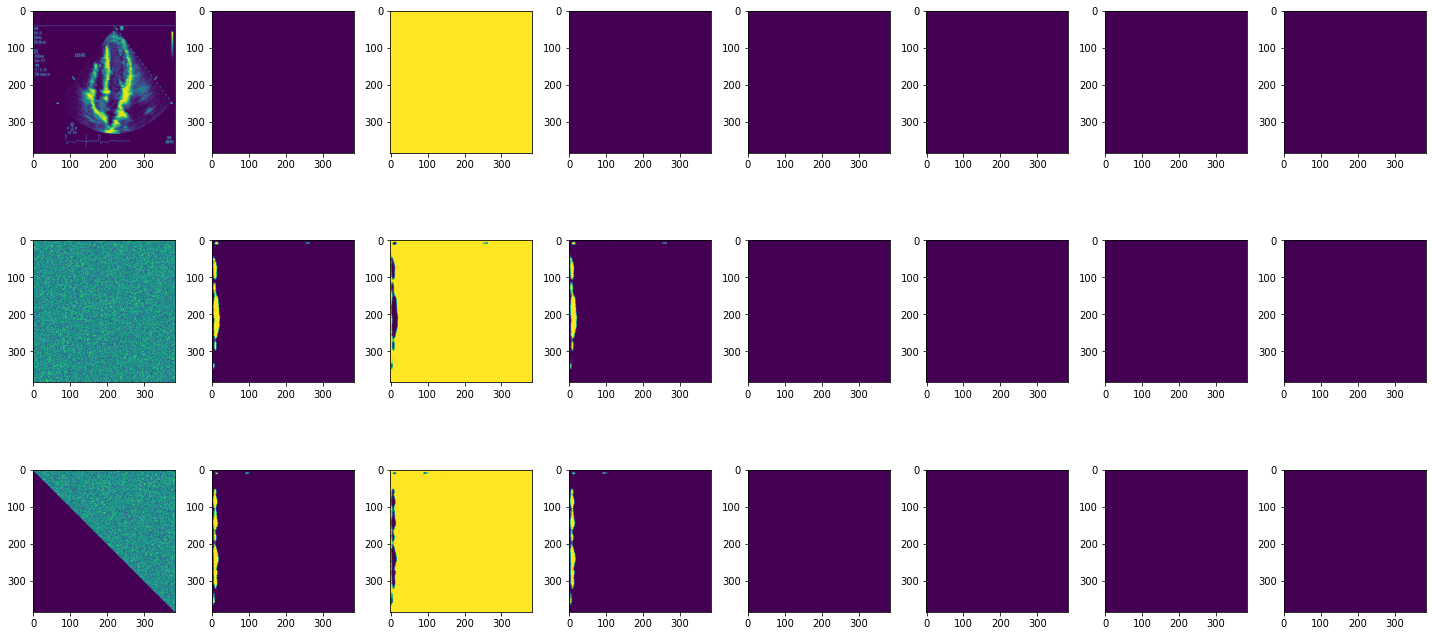

In [200]:
fig, (ax1, ax2, ax3) = plt.subplots(3, label_dim+2, figsize=(20,10))

i = 20
seg_img = softmax(model.predict(sess, images[i:i+1])[0,:,:,:])
pred_img = np.argmax(seg_img, 2)
ax1[0].imshow(images[i])
ax1[1].imshow(pred_img)
for i, a in enumerate(ax1[2:]):
    a.imshow(seg_img[:, :, i], vmin=0, vmax=1)

rand = np.random.randint(0, 255, size=images[i:i+1].shape)
ax2[0].imshow(rand[0])
seg_rand = softmax(model.predict(sess, rand)[0,:,:,:])
pred_rand = np.argmax(seg_rand, 2)
ax2[1].imshow(pred_rand)
for i, a in enumerate(ax2[2:]):
    a.imshow(seg_rand[:, :, i], vmin=0, vmax=1)
    
rand2 = np.random.randint(0, 255, size=images[i:i+1].shape)
tri = np.triu(rand2.reshape(384, 384))
seg_tri = softmax(model.predict(sess, rand2.reshape(1, 384, 384, 1))[0,:,:,:])
pred_tri = np.argmax(seg_tri, 2)
ax3[0].imshow(tri)
ax3[1].imshow(pred_tri)
for i, a in enumerate(ax3[2:]):
    a.imshow(seg_tri[:, :, i], vmin=0, vmax=1)

plt.tight_layout()

In [ ]:
model.predict()

In [ ]:
plt.imshow(images[:1].reshape(384, 384))

In [ ]:
pred = model.predict(sess, images[i:i+1])[0]

In [ ]:
for i in range(len(images)):
    seg = np.argmax(model.predict(sess, images[i:i+1])[0,:,:,:], 2)

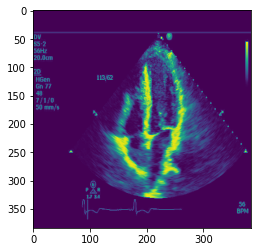

In [23]:
plt.imshow(images[0]-24)

In [20]:
g_6 = tf.Graph()
with g_6.as_default():
    label_dim = 6
    sess6 = tf.Session()
    model6 = Unet(mean, weight_decay, learning_rate, label_dim, maxout=maxout)
    # sess6.run(tf.local_variables_initializer())
    sess = sess6
    model = model6
    sess.run((model6.pred), feed_dict={model.x_test: images[0:1]})

2022-08-25 11:37:20.944891: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22665 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-08-25 11:37:20.945773: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22843 MB memory:  -> device: 1, name: NVIDIA TITAN RTX, pci bus id: 0000:d8:00.0, compute capability: 7.5


FailedPreconditionError: Graph execution error:

Detected at node 'vgg_1/up9/conv2d_transpose/ReadVariableOp' defined at (most recent call last):
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/nea914/.local/lib/python3.9/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/nea914/.local/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/nea914/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/nea914/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/nea914/.local/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/nea914/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/nea914/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/nea914/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_35548/2130526586.py", line 5, in <cell line: 2>
      model6 = Unet(mean, weight_decay, learning_rate, label_dim, maxout=maxout)
    File "/home/nea914/echocv3/segment_a4c_a2c_a3c_plax_psax.py", line 32, in __init__
      self.pred = self.unet(self.x_test, mean, keep_prob = 1.0, reuse = True)
    File "/home/nea914/echocv3/segment_a4c_a2c_a3c_plax_psax.py", line 94, in unet
      up_9 = tf.concat([deconv_(conv_8_2, int(256*width), 'up9'), conv_3_2], 3)
    File "/home/nea914/echocv3/segment_a4c_a2c_a3c_plax_psax.py", line 53, in <lambda>
      deconv_ = lambda x, output_depth, name: deconv(x, 2, output_depth, 2, weight_decay, name=name)
    File "/home/nea914/echocv3/util.py", line 90, in deconv
      return tf.layers.conv2d_transpose(x, num_filters, filter_size, stride, padding=padding, kernel_initializer=tf.keras.initializers.glorot_normal(), activation=activation, name=name)
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/keras/legacy_tf_layers/convolutional.py", line 1736, in conv2d_transpose
      return layer(inputs)
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/keras/legacy_tf_layers/base.py", line 569, in __call__
      outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/keras/engine/base_layer_v1.py", line 763, in __call__
      outputs = call_fn(cast_inputs, *args, **kwargs)
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/keras/layers/convolutional/conv2d_transpose.py", line 275, in call
      outputs = backend.conv2d_transpose(
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/keras/backend.py", line 5756, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(x, kernel, output_shape, strides,
Node: 'vgg_1/up9/conv2d_transpose/ReadVariableOp'
Detected at node 'vgg_1/up9/conv2d_transpose/ReadVariableOp' defined at (most recent call last):
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/nea914/.local/lib/python3.9/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/nea914/.local/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/nea914/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/nea914/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/nea914/.local/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/nea914/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/nea914/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/nea914/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_35548/2130526586.py", line 5, in <cell line: 2>
      model6 = Unet(mean, weight_decay, learning_rate, label_dim, maxout=maxout)
    File "/home/nea914/echocv3/segment_a4c_a2c_a3c_plax_psax.py", line 32, in __init__
      self.pred = self.unet(self.x_test, mean, keep_prob = 1.0, reuse = True)
    File "/home/nea914/echocv3/segment_a4c_a2c_a3c_plax_psax.py", line 94, in unet
      up_9 = tf.concat([deconv_(conv_8_2, int(256*width), 'up9'), conv_3_2], 3)
    File "/home/nea914/echocv3/segment_a4c_a2c_a3c_plax_psax.py", line 53, in <lambda>
      deconv_ = lambda x, output_depth, name: deconv(x, 2, output_depth, 2, weight_decay, name=name)
    File "/home/nea914/echocv3/util.py", line 90, in deconv
      return tf.layers.conv2d_transpose(x, num_filters, filter_size, stride, padding=padding, kernel_initializer=tf.keras.initializers.glorot_normal(), activation=activation, name=name)
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/keras/legacy_tf_layers/convolutional.py", line 1736, in conv2d_transpose
      return layer(inputs)
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/keras/legacy_tf_layers/base.py", line 569, in __call__
      outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/keras/engine/base_layer_v1.py", line 763, in __call__
      outputs = call_fn(cast_inputs, *args, **kwargs)
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/keras/layers/convolutional/conv2d_transpose.py", line 275, in call
      outputs = backend.conv2d_transpose(
    File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/keras/backend.py", line 5756, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(x, kernel, output_shape, strides,
Node: 'vgg_1/up9/conv2d_transpose/ReadVariableOp'
2 root error(s) found.
  (0) FAILED_PRECONDITION: Could not find variable vgg/up9/kernel. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Container localhost does not exist. (Could not find resource: localhost/vgg/up9/kernel)
	 [[{{node vgg_1/up9/conv2d_transpose/ReadVariableOp}}]]
	 [[vgg_1/conv12_2/add/_3]]
  (1) FAILED_PRECONDITION: Could not find variable vgg/up9/kernel. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Container localhost does not exist. (Could not find resource: localhost/vgg/up9/kernel)
	 [[{{node vgg_1/up9/conv2d_transpose/ReadVariableOp}}]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'vgg_1/up9/conv2d_transpose/ReadVariableOp':
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/nea914/.local/lib/python3.9/site-packages/traitlets/config/application.py", line 976, in launch_instance
    app.start()
  File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/home/nea914/.local/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
    self._run_once()
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
    handle._run()
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
    await self.process_one()
  File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
    await dispatch(*args)
  File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
    await result
  File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
    reply_content = await reply_content
  File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
    res = shell.run_cell(
  File "/home/nea914/.local/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/nea914/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
    result = self._run_cell(
  File "/home/nea914/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
    return runner(coro)
  File "/home/nea914/.local/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/home/nea914/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/nea914/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/nea914/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_35548/2130526586.py", line 5, in <cell line: 2>
    model6 = Unet(mean, weight_decay, learning_rate, label_dim, maxout=maxout)
  File "/home/nea914/echocv3/segment_a4c_a2c_a3c_plax_psax.py", line 32, in __init__
    self.pred = self.unet(self.x_test, mean, keep_prob = 1.0, reuse = True)
  File "/home/nea914/echocv3/segment_a4c_a2c_a3c_plax_psax.py", line 94, in unet
    up_9 = tf.concat([deconv_(conv_8_2, int(256*width), 'up9'), conv_3_2], 3)
  File "/home/nea914/echocv3/segment_a4c_a2c_a3c_plax_psax.py", line 53, in <lambda>
    deconv_ = lambda x, output_depth, name: deconv(x, 2, output_depth, 2, weight_decay, name=name)
  File "/home/nea914/echocv3/util.py", line 90, in deconv
    return tf.layers.conv2d_transpose(x, num_filters, filter_size, stride, padding=padding, kernel_initializer=tf.keras.initializers.glorot_normal(), activation=activation, name=name)
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/keras/legacy_tf_layers/convolutional.py", line 1736, in conv2d_transpose
    return layer(inputs)
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/keras/legacy_tf_layers/base.py", line 569, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/keras/engine/base_layer_v1.py", line 763, in __call__
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 689, in wrapper
    return converted_call(f, args, kwargs, options=options)
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 331, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 458, in _call_unconverted
    return f(*args, **kwargs)
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/keras/layers/convolutional/conv2d_transpose.py", line 275, in call
    outputs = backend.conv2d_transpose(
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py", line 1082, in op_dispatch_handler
    return dispatch_target(*args, **kwargs)
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/keras/backend.py", line 5756, in conv2d_transpose
    x = tf.compat.v1.nn.conv2d_transpose(x, kernel, output_shape, strides,
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py", line 1082, in op_dispatch_handler
    return dispatch_target(*args, **kwargs)
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/ops/nn_ops.py", line 2644, in conv2d_transpose
    return conv2d_transpose_v2(
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py", line 1082, in op_dispatch_handler
    return dispatch_target(*args, **kwargs)
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/ops/nn_ops.py", line 2730, in conv2d_transpose_v2
    return gen_nn_ops.conv2d_backprop_input(
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1285, in conv2d_backprop_input
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py", line 779, in _apply_op_helper
    _ExtractInputsAndAttrs(op_type_name, op_def, allowed_list_attr_map,
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py", line 552, in _ExtractInputsAndAttrs
    values = ops.convert_to_tensor(
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/profiler/trace.py", line 183, in wrapped
    return func(*args, **kwargs)
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 1640, in convert_to_tensor
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 2077, in _dense_var_to_tensor
    return var._dense_var_to_tensor(dtype=dtype, name=name, as_ref=as_ref)  # pylint: disable=protected-access
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 1438, in _dense_var_to_tensor
    return self.value()
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 582, in value
    return self._read_variable_op()
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 691, in _read_variable_op
    result = read_and_set_handle()
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 681, in read_and_set_handle
    result = gen_resource_variable_ops.read_variable_op(
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/ops/gen_resource_variable_ops.py", line 493, in read_variable_op
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py", line 797, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 3754, in _create_op_internal
    ret = Operation(
  File "/home/nea914/miniconda3/envs/echocv/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 2133, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)
